# Step Functions
In many experimental setups, dynamic loads are applied to simulate realistic operating conditions. Experimental platforms often handle these dynamic loads effectively, interpolating between data points if necessary to create smooth profiles. However, while interpolation is a convenient tool, there are situations where it might not be the best approach for simulating system behavior. Therefore, we also supply helper functions to construct step-based load profiles.

## Why not interpolate?
Interpolating data can introduce a level of artificial smoothness that doesn't always reflect the abrupt changes seen in real-world systems. For example, interpolated loads are often used to ease solver convergence, but they may not capture the behavior of systems that respond rapidly to changes. This is particularly important for systems that exhibit stepwise or discrete changes in load, where instantaneous shifts between levels are more appropriate than a continuous curve.

While writing an interpolation function is typically straightforward—requiring little more than a call to a standard library, the complexity increases when building a function that implements stepwise behavior. A step function requires more careful attention to correctly represent when and where the system load changes instantaneously. Consequently, we provide this functionality within the `loadfns` modeule to reduce the users' burden to have to develop their own. 

## Overview
When dealing with numerical simulations, introducing ramps between load changes can significantly improve the stability of the solver, reducing the risk of failure during abrupt transitions. Sudden, instantaneous changes in load can sometimes cause solvers to struggle, especially with stiff systems, leading to crashes or errors. That’s why `thevenin` offers two classes for defining stepped load profiles: `StepFunction` and `RampedSteps`.

The `StepFunction` class is designed for scenarios where immediate, instantaneous changes in load are appropriate, while the `RampedSteps` class helps transition between steps by applying an interpolation ramps over a specified time interval at the start of each new step. These two approaches cover a wide range of scenarios, from systems that can handle rapid shifts to those that require more stable transitions.

Below, we will cover:
1. Building load profiles using interpolated data.
2. Setting up multi-step experiments using for loops.
3. Using the `StepFunctio` class to create instantaneous stepped loads.
4. Using the `RampedSteps` class to create stable transitions between load steps.

## Dynamic Experiments
To create dynamic load profiles, especially for more complex experiments, there are many approaches you can take. The `Experiment` class allows users to pass in any Python `Callable` like `f(t: float) -> float` to control each step. Therefore, if you have data, you can easily interpolate the data to create a load profile, or you can automate the construction of load steps using a for loop. Below we demonstrate both approaches.


[thevenin UserWarning] Using the default parameter file 'params.yaml'.



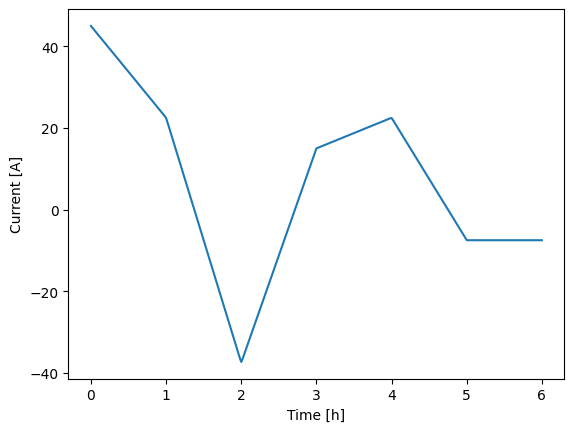

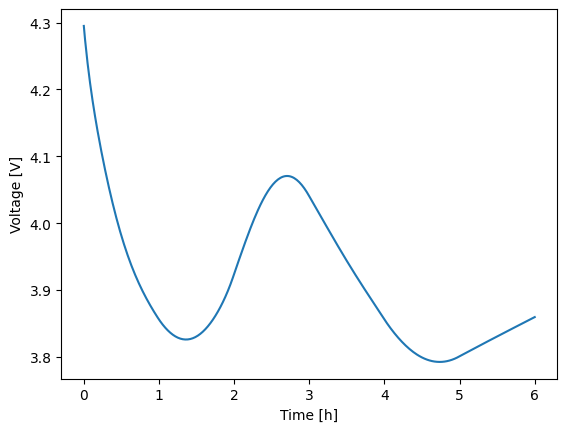

In [1]:
import thevenin as thev
import numpy as np

model = thev.Model()

# Fake hour-by-hour load data
time_s = 3600.*np.array([0., 1., 2., 3., 4., 5.])
current_A = model.capacity*np.array([0.6, 0.3, -0.5, 0.2, 0.3, -0.1])

# Interpolating the data
interp = lambda t: np.interp(t, time_s, current_A)

expr = thev.Experiment(max_step=60.)
expr.add_step('current_A', interp, (3600*6, 60.))

soln = model.run(expr)
soln.plot('time_h', 'current_A')
soln.plot('time_h', 'voltage_V')


In the script above, the data represents hour-by-hour constant-current loads, which might represent some stationary storage system. Since the current is constant across each hour, interpolating between points poorly approximates the actual system behavior. However, interpolation might be more relevant for other dynamic systems like electric vehicles, where data is resolved on shorter timescales, such as seconds.

A better approach for modeling constant-step experiments, rather than using interpolation, is to manually construct the steps using a for loop. In the code block below, we demonstrate how to create a new experiment with multiple steps, where each step lasts one hour, and the current is set by the values in the `current_A` array.

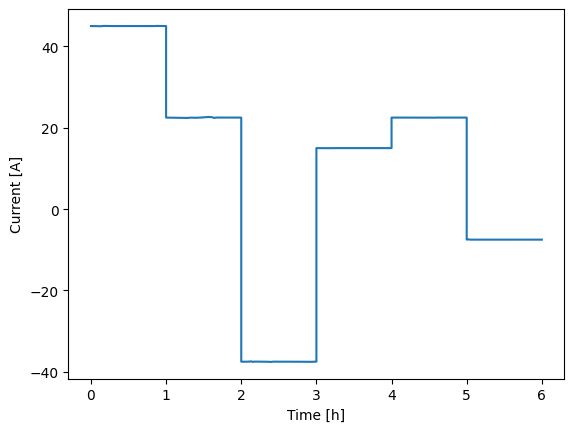

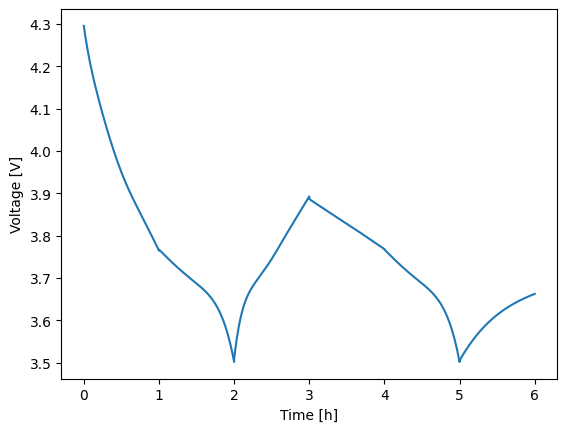

In [2]:
# Looping over constant steps
expr = thev.Experiment(max_step=60.)
for amps in current_A:
    expr.add_step('current_A', amps, (3600, 60.))

soln = model.run(expr)
soln.plot('time_h', 'current_A')
soln.plot('time_h', 'voltage_V')

This loop-based method significantly improves the accuracy of the results in this case. You can see how different the two voltage profiles are when the load profile is applied correctly, instead of using interpolation. This loop-based approach offers the most flexibility and is recommended when users need precise control over each step. For example, using the `add_step` method allows you to add different limits to each step, which can be incorporated into the loop. This level of control is not always possible with other methods.

## Ramped Transitions
Unlike `StepFunction`, the `RampedSteps` class introduces "smooth" transitions between load steps by ramping up or down over a specified time period. This method is especially useful when dealing with stiff systems, where abrupt changes might otherwise cause solver instability. Below we demonstrate this using the same hour-by-hour profile from above. We set the ramp between steps to be just one millisecond so that the transitions are still quick and approximate an instantaneous change. In this case, the added ramps improve the stability and the full simulation is run, as shown in the figure. Overall, the results are nearly identical to the loop-based approach since the ramps are set to occur over such a small time scale. In particular, the main difference is shown in the current profile, where you can briefly see the first ramp (starting from zero current at `t = 0`).

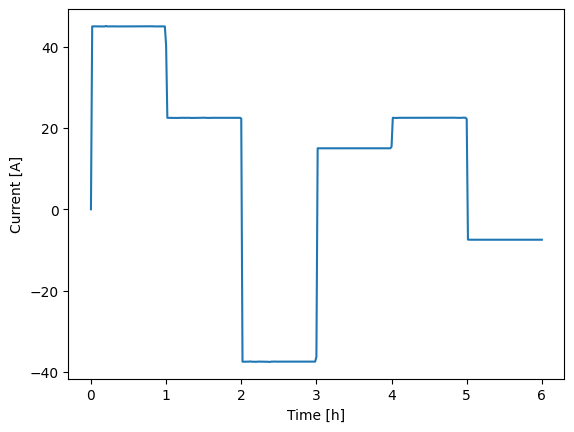

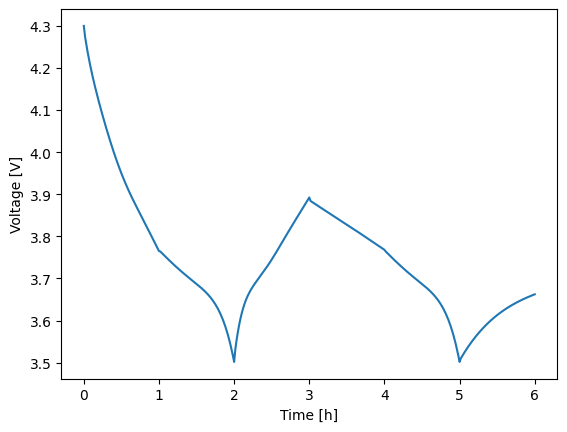

In [3]:
# Stabilize the solver with ramped steps
demand = thev.loadfns.RampedSteps(time_s, current_A, 1e-3)

expr = thev.Experiment(max_step=60.)
expr.add_step('current_A', demand, (3600*6, 60.))

soln = model.run(expr)
soln.plot('time_h', 'current_A')
soln.plot('time_h', 'voltage_V')

While the `RampedSteps` class improves solver stability, it still lacks flexibility for setting limits on each individual step. For instance, you could apply limits to stop the simulation if the voltage goes outside a specific window (e.g., [3, 4.2]), but this would simply end the entire simulation prematurely. In most cases, you wouldn’t want to stop the simulation completely but instead transition to the next step early. To achieve this behavior, you would need to use loops, or alternatively, set up multiple instances of the `RampedSteps` class if you want to transition between groups of steps based on specific limits rather than between individual steps.

In general, if maximum flexibility is needed, more manual setup is required for multi-step experiments. However, if you can work within the limitations of `RampedSteps`, it is a powerful tool for quickly constructing step-like profiles while maintaining some degree of stability.

## Conclusion
In this tutorial, we explored various methods for constructing dynamic load profiles using the `StepFunction` and `RampedSteps` classes. We’ve shown how both instantaneous steps and ramps between steps can be modeled and discussed the trade-offs between flexibility, stability, and ease of use. While loop-based approaches offer the greatest control, `RampedSteps` provides a simple and effective way to ensure stability in simulations, making it a valuable option for many users. Ultimately, the best method depends on the complexity of the load profile you need and the requirements of your specific experiment or model.